In [3]:
import pydpmd as dp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import numpy as np
import h5py
from tqdm import tqdm
from pydpmd.plot import draw_particles_frame

def read_data_from_ragged(f, key):
    data_dict = f[f'ragged/{key}']
    sorted_pd_keys = sorted(list(data_dict.keys()), key=lambda s: int(s.rsplit('_', 1)[1]))
    return [data_dict[k][()] for k in sorted_pd_keys]

def get_idx_in_B(A, B):
    mapping = { (x, y): i for i, (x, y) in enumerate(B) }
    return np.fromiter((mapping[tuple(row)] for row in A), dtype=int, count=A.shape[0])

def read_ragged(path):
    with h5py.File(path, 'r') as f:
        pair_dist = read_data_from_ragged(f, 'pair_dist')
        pair_forces = read_data_from_ragged(f, 'pair_forces')
        pair_ids = read_data_from_ragged(f, 'pair_ids')
    unique_pair_ids = np.unique(np.concatenate(pair_ids), axis=0)

    pair_dist_full = np.zeros((len(pair_dist), len(unique_pair_ids)))
    pair_forces_full = np.zeros((len(pair_dist), len(unique_pair_ids), 2))
    pair_ids_full = np.array([unique_pair_ids for i in range(len(pair_dist))])

    for i in tqdm(range(len(pair_dist))):
        mapped_ids = get_idx_in_B(pair_ids[i], pair_ids_full[i])
        pair_forces_full[i, mapped_ids] = pair_forces[i]
        pair_dist_full[i, mapped_ids] = pair_dist[i]
    return pair_dist_full, pair_forces_full, pair_ids_full

In [ ]:
root = '/home/mmccraw/dev/data/11-06-25/effective_potential/N-100/'

df = {
    'nv': [],
    'mu': [],
    'min_delta': [],
    'delta': [],
    'force': [],
}

for ptype in tqdm(os.listdir(root)):

    path = os.path.join(root, ptype, 'jamming_2')
    data = dp.data.load(path, location=['final', 'init'], load_trajectory=True, load_full=False)
    data.calculate_mu_eff()

    nv, mu = ptype.split('-')
    nv = int(nv)

    df['mu'].append(data.mu_eff[0])
    df['nv'].append(nv)

    N = data.system_size - 1
    d = 3
    ke = data.trajectory.ke_total.copy()
    temp = 2 * np.mean([data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())], axis=0) / (N * d)

    d = np.load(os.path.join(path, 'pairs.npz'))
    pair_dist = d['pair_dist']
    pair_force = d['pair_force']
    pair_ids = d['pair_ids']

    pair_force[pair_dist == 0] = np.nan
    pair_dist[pair_dist == 0] = np.nan

    mean_delta = -np.nanmean(np.sum(data.rad[pair_ids], axis=-1) - pair_dist, axis=0)
    mean_force = np.nanmean(np.linalg.norm(pair_force, axis=-1), axis=0)
    force_norm = mean_force / temp[data.system_id[pair_ids[0, :, 0]]]

    min_delta = np.min(-(np.sum(data.rad[pair_ids], axis=-1) - pair_dist)[np.linalg.norm(pair_force, axis=-1) == 0])

    df['min_delta'].append(min_delta)
    df['force'].append(force_norm)
    df['delta'].append(mean_delta)

df = pd.DataFrame(df)

100%|██████████| 30/30 [02:02<00:00,  4.09s/it]


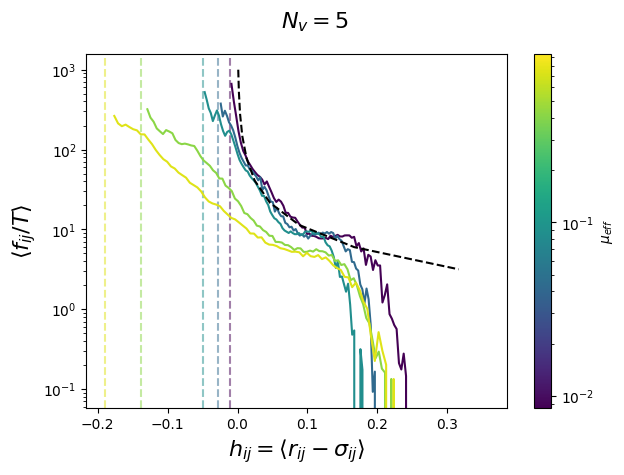

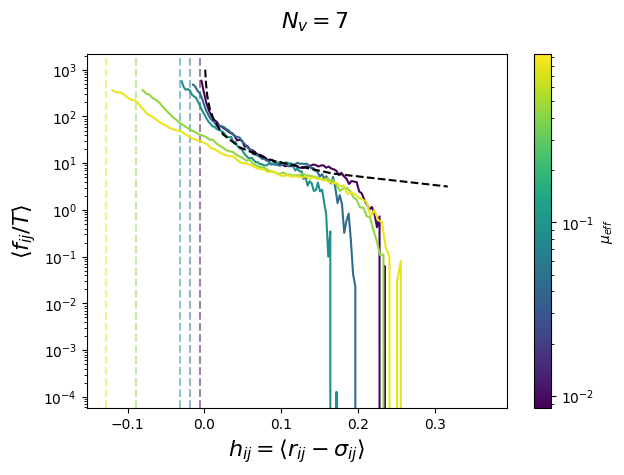

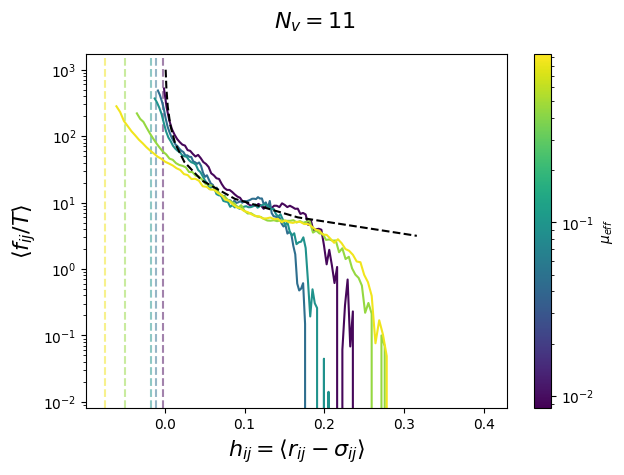

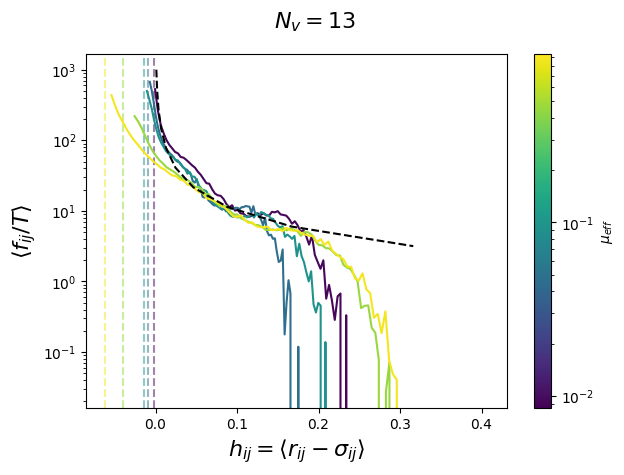

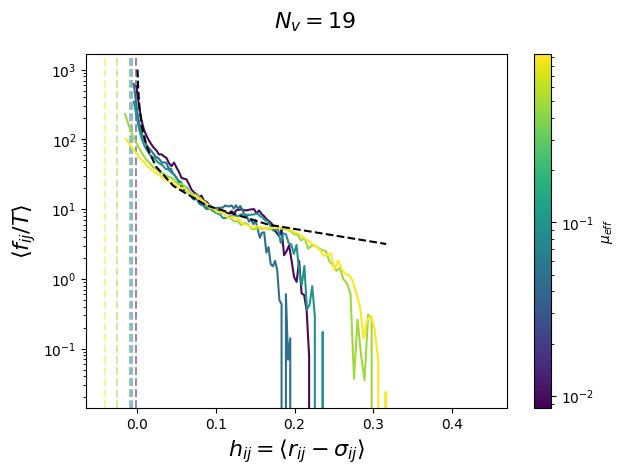

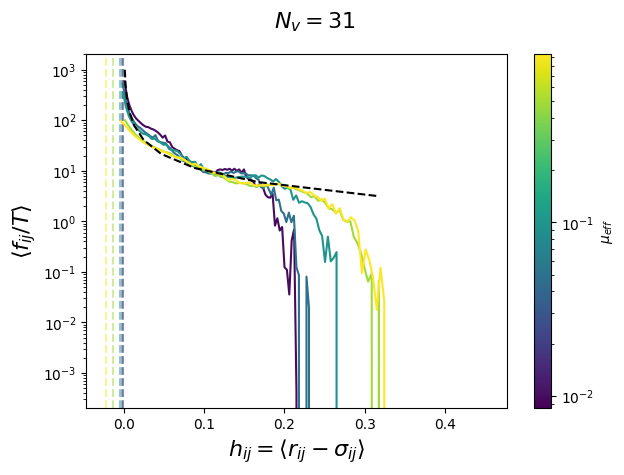

In [166]:
n_bins = 100

mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu):
        mask = (df.nv == nv) & (df.mu == mu)
        if not np.any(mask):
            continue
        delta = df[mask].delta.values[0]
        force = df[mask].force.values[0]
        min_delta = df[mask].min_delta.values[0]

        delta_bins = np.linspace(np.min(delta), np.max(delta), n_bins+2)[1:-1]

        bin_ids = np.digitize(delta, delta_bins)
        force_bins = np.zeros_like(delta_bins)
        force_std_1 = np.zeros_like(delta_bins)
        force_std_2 = np.zeros_like(delta_bins)

        for i in range(len(delta_bins)):
            if not np.any(bin_ids == i):
                continue
            force_bins[i] = np.mean(force[bin_ids == i])
            force_std_1[i] = np.quantile(force[bin_ids == i], q=0.25)
            force_std_2[i] = np.quantile(force[bin_ids == i], q=0.75)

        plt.plot(delta_bins, force_bins, c=cmap(mu_norm(mu)))
        plt.axvline(min_delta, c=cmap(mu_norm(mu)), linestyle='--', alpha=0.5, zorder=0)
        # plt.plot(delta_bins, force_std_1, color='k', alpha=0.5, zorder=0)
        # plt.plot(delta_bins, force_std_2, color='k', alpha=0.5, zorder=0)
    plt.yscale('log')
    # plt.xscale('symlog', linthresh=1e-4)

    x = np.logspace(-3, -0.5, 10)
    plt.plot(x, 1/x, c='k', linestyle='--')

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.xlabel(r'$h_{ij}=\langle r_{ij}-\sigma_{ij} \rangle$', fontsize=16)
    plt.ylabel(r'$\langle f_{ij} / T \rangle$', fontsize=16)

    plt.suptitle(fr'$N_v=${nv}', fontsize=16)
    plt.tight_layout()

    os.makedirs('figures/eff-force-lin/', exist_ok=True)
    plt.savefig(f'figures/eff-force-lin/NV-{nv}.png', dpi=600)

    plt.show()

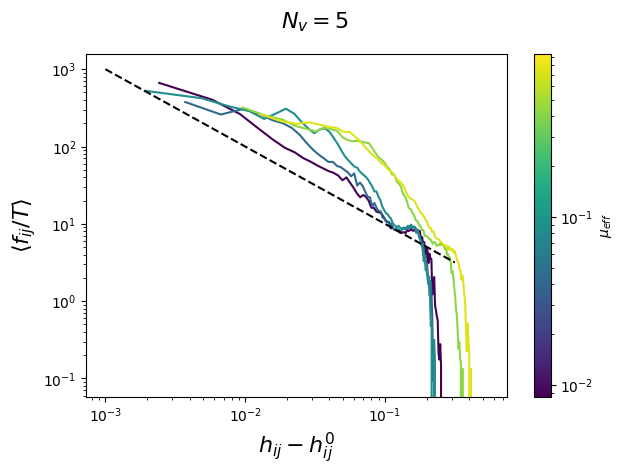

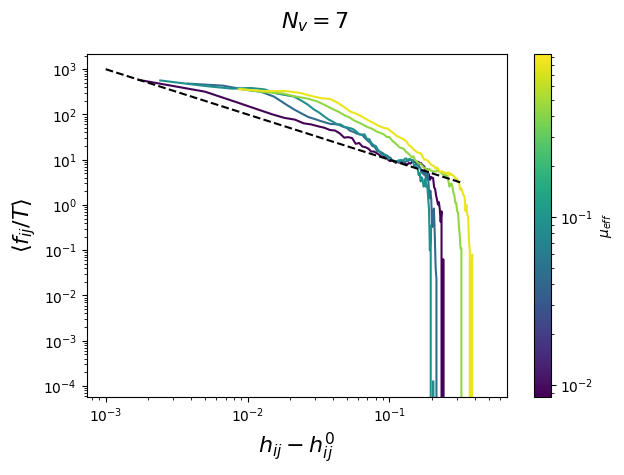

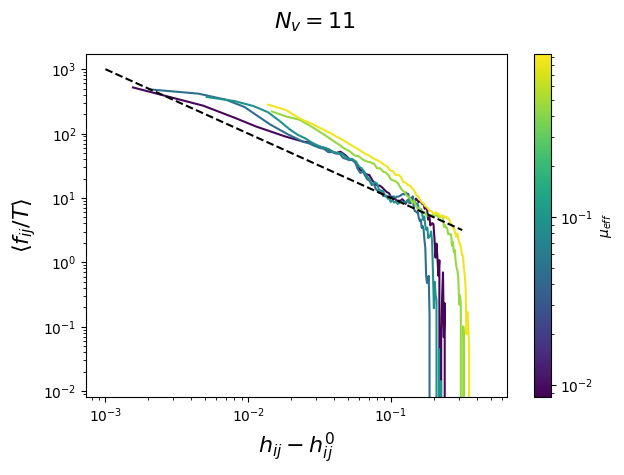

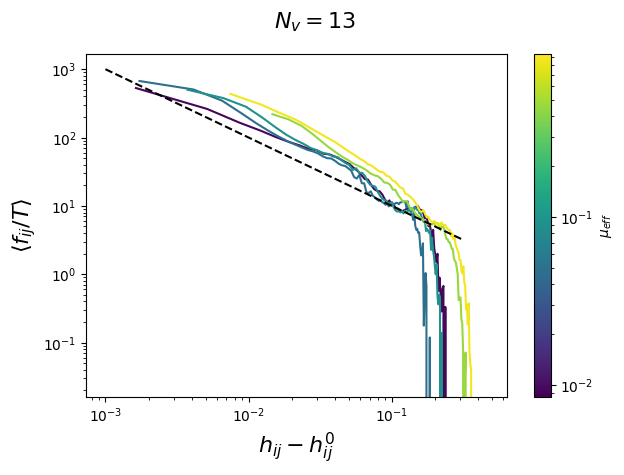

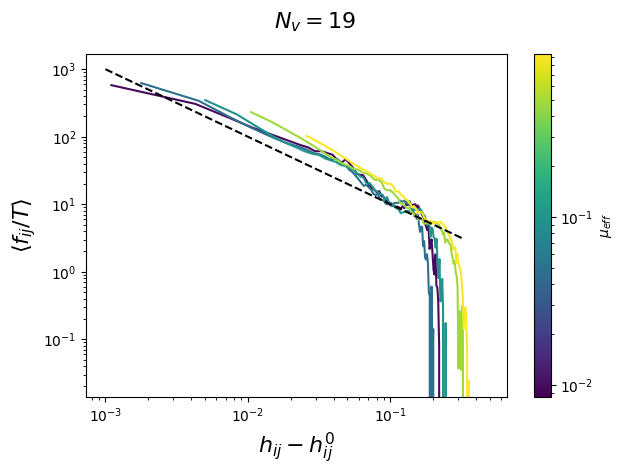

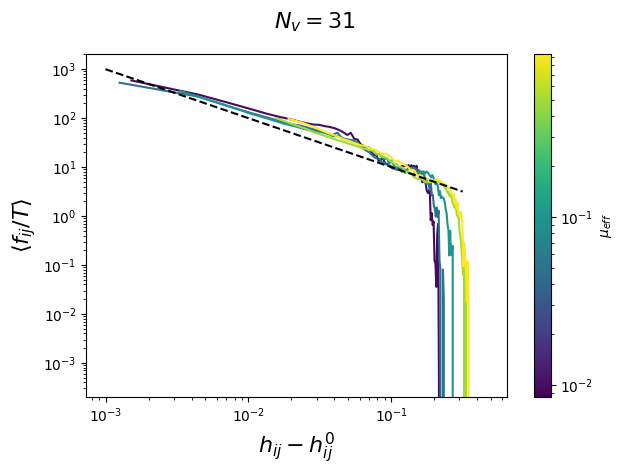

In [167]:
n_bins = 100

mu_norm = LogNorm(vmin=np.min(df.mu), vmax=np.max(df.mu))
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu):
        mask = (df.nv == nv) & (df.mu == mu)
        if not np.any(mask):
            continue
        delta = df[mask].delta.values[0]
        force = df[mask].force.values[0]
        min_delta = df[mask].min_delta.values[0]

        delta_bins = np.linspace(np.min(delta), np.max(delta), n_bins+2)[1:-1]

        bin_ids = np.digitize(delta, delta_bins)
        force_bins = np.zeros_like(delta_bins)
        force_std_1 = np.zeros_like(delta_bins)
        force_std_2 = np.zeros_like(delta_bins)

        for i in range(len(delta_bins)):
            if not np.any(bin_ids == i):
                continue
            force_bins[i] = np.mean(force[bin_ids == i])
            force_std_1[i] = np.quantile(force[bin_ids == i], q=0.25)
            force_std_2[i] = np.quantile(force[bin_ids == i], q=0.75)

        plt.plot(delta_bins - min_delta, force_bins, c=cmap(mu_norm(mu)))
        # plt.plot(delta_bins, force_std_1, color='k', alpha=0.5, zorder=0)
        # plt.plot(delta_bins, force_std_2, color='k', alpha=0.5, zorder=0)
    plt.yscale('log')
    plt.xscale('log')
    # plt.xscale('symlog', linthresh=1e-4)

    x = np.logspace(-3, -0.5, 10)
    plt.plot(x, 1/x, c='k', linestyle='--')

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.xlabel(r'$h_{ij}-h_{ij}^0$', fontsize=16)
    plt.ylabel(r'$\langle f_{ij} / T \rangle$', fontsize=16)

    plt.suptitle(fr'$N_v=${nv}', fontsize=16)
    plt.tight_layout()

    os.makedirs('figures/eff-force-delta/', exist_ok=True)
    plt.savefig(f'figures/eff-force-delta/NV-{nv}.png', dpi=600)

    plt.show()

In [162]:
ptype = '13-0.01'  # for ptype in os.listdir(root)

nv = int(ptype.split('-')[0])

path = os.path.join(root, ptype, 'jamming_2')
data = dp.data.load(path, location=['final', 'init'], load_trajectory=True, load_full=True)
data.calculate_mu_eff()
mu = data.mu_eff[0]

N = data.system_size - 1
d = 3
ke = data.trajectory.ke_total.copy()
temp = 2 * np.mean(ke, axis=0) / (N * d)

d = np.load(os.path.join(path, 'pairs.npz'))
pair_dist = d['pair_dist']
pair_force = d['pair_force']
pair_ids = d['pair_ids']

pair_force[pair_dist == 0] = np.nan
pair_dist[pair_dist == 0] = np.nan

delta_phi_norm = LogNorm(vmin=np.min(np.abs(data.delta_phi)), vmax=np.max(np.abs(data.delta_phi)))
cmap = plt.cm.viridis

mean_delta = -np.nanmean(np.sum(data.rad[pair_ids], axis=-1) - pair_dist, axis=0)
mean_force = np.nanmean(np.linalg.norm(pair_force, axis=-1), axis=0)
force_norm = mean_force / temp[data.system_id[pair_ids[0, :, 0]]]

Loading trajectory: 100%|██████████| 3/3 [00:00<00:00, 77.92it/s]


/tmp/ipykernel_200058/3627339377.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(mean_delta[pair_mask], mean_force[pair_mask] / temp[sid], s=1, c=cmap(delta_phi_norm(np.abs(delta_phi))))


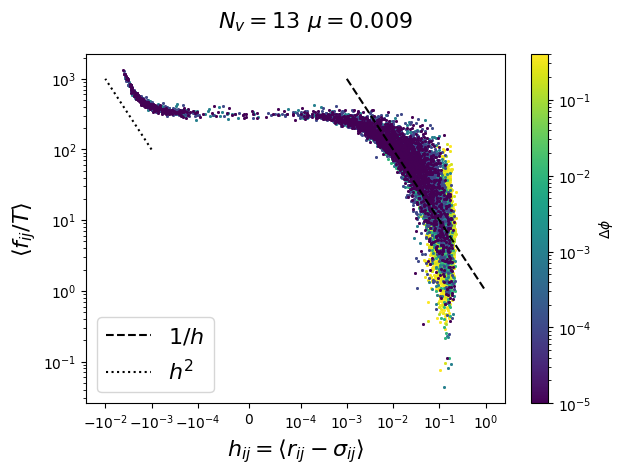

In [165]:
sids = np.arange(data.delta_phi.size)

for delta_phi in np.unique(data.delta_phi):
    mask = data.delta_phi == delta_phi

    for sid in sids[mask]:
        beg = data.system_offset[sid]
        end = data.system_offset[sid + 1]

        pair_mask = np.all((pair_ids[..., 0] >= beg) & (pair_ids[..., 1] < end), axis=0)
        plt.scatter(mean_delta[pair_mask], mean_force[pair_mask] / temp[sid], s=1, c=cmap(delta_phi_norm(np.abs(delta_phi))))

x = np.logspace(-3, 0, 10)
plt.plot(x, 1/x, c='k', linestyle='--', label=r'$1/h$')

x = np.logspace(-3, -2, 10)
plt.plot(-x, x * 1e5, c='k', linestyle=':', label=r'$h^2$')

plt.xscale('symlog', linthresh=1e-4)
plt.yscale('log')

plt.legend(fontsize=16)

sm = plt.cm.ScalarMappable(norm=delta_phi_norm, cmap=cmap)
sm.set_array(np.abs(data.delta_phi))
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\Delta \phi$')

plt.xlabel(r'$h_{ij}=\langle r_{ij}-\sigma_{ij} \rangle$', fontsize=16)
plt.ylabel(r'$\langle f_{ij} / T \rangle$', fontsize=16)

plt.suptitle(rf'$N_v=${nv} $\mu=${mu:.3f}', fontsize=16)
plt.tight_layout()
plt.savefig('figures/example.png', dpi=600)